# Fake Review Detector

### Importing the necessary libraries

In [1]:
!pip install nltk


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import string
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
# from sklearn.naive_bayes import MultinomialNB
# from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

In [30]:
# nltk.download('punkt')
# nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\reshu\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

### Supressing warnings

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Loading the dataset

In [5]:
df = pd.read_csv(r'fake-reviews-dataset.csv')

df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


## Preprocessing

In [6]:
df.drop(columns = {'category'}, inplace = True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rating  40432 non-null  float64
 1   label   40432 non-null  object 
 2   text_   40432 non-null  object 
dtypes: float64(1), object(2)
memory usage: 947.8+ KB


In [8]:
df.rename(columns = {'text_': 'text'}, inplace = True)

In [9]:
df.head()

,rating,label,text
0,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,5.0,CG,"love it, a great upgrade from the original. I..."
2,5.0,CG,This pillow saved my back. I love the look and...
3,1.0,CG,"Missing information on how to use it, but it i..."
4,5.0,CG,Very nice set. Good quality. We have had the s...


### Label encoding

In [10]:
def encode_label(df):
    labels = {
        'CG': 0,
        'OR': 1
    }
    
    df['target'] = df['label'].map(labels)
    
    return df

In [11]:
df = encode_label(df)
df['target'] = df['target'].fillna(0).replace([np.inf, -np.inf], 0)
df['target'] = df['target'].astype(int)

df.head()

,rating,label,text,target
0,5.0,CG,"Love this! Well made, sturdy, and very comfor...",0
1,5.0,CG,"love it, a great upgrade from the original. I...",0
2,5.0,CG,This pillow saved my back. I love the look and...,0
3,1.0,CG,"Missing information on how to use it, but it i...",0
4,5.0,CG,Very nice set. Good quality. We have had the s...,0


In [12]:
df.drop(columns = {'rating', 'label'}, inplace = True)

In [13]:
df = df.sample(frac=1).reset_index(drop=True)

df.sample(10)

,text,target
20359,"Same as another review, I use it at the gym. I...",0
21890,Old format and examples that are easy to under...,0
8554,"Using with my Samsung Galaxy Tab 2, the only t...",0
8927,Light output is amazing and looks great. It is...,0
11700,I only watched this on TV a few years ago. I s...,0
20257,Work well. I have two. WARNING: NO TURN FOR LI...,0
33934,Slightly dented when I got it. It did the job...,1
13416,*I received this Advance Reader Copy of the bo...,0
1991,I give this movie 5 stars because it is very f...,0
6600,great doorbell! I am using it to replace an o...,1


In [14]:
df.isnull().sum()

text      0
target    0
dtype: int64

In [15]:
df.duplicated().sum()

np.int64(20)

In [16]:
df.drop_duplicates(inplace = True)

In [17]:
df.duplicated().sum()

np.int64(0)

In [18]:
df['target'].value_counts()

target
1    20215
0    20197
Name: count, dtype: int64

## EDA

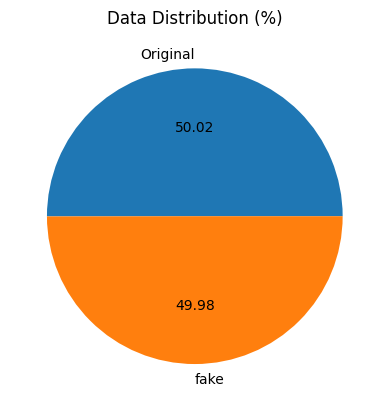

In [19]:
plt.pie(df['target'].value_counts(), labels=['Original', 'fake'],autopct="%0.2f")

plt.title("Data Distribution (%)")
plt.show()

In [22]:
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [23]:
df.head()

,text,target,num_characters,num_words,num_sentences
0,"I waited years for this book to be released, a...",0,614,152,14
1,This was a DVD for my 2 year old grand daughte...,1,152,33,1
2,"Finally found a new MC, an old friend, and a n...",0,886,187,13
3,I returned because this shoe fit like a mans. ...,1,79,20,2
4,"It is ok, just not what I expected. Very good ...",0,77,20,4


In [24]:
df.describe()

,target,num_characters,num_words,num_sentences
count,40412.000000,40412.000000,40412.000000,40412.000000
mean,0.500223,351.365337,76.691131,5.277071
std,0.500006,369.871842,79.242859,4.915033
min,0.000000,24.000000,2.000000,1.000000
25%,0.000000,107.000000,24.000000,2.000000
50%,1.000000,198.000000,44.000000,3.000000
75%,1.000000,439.000000,96.000000,6.000000
max,1.000000,2827.000000,510.000000,133.000000


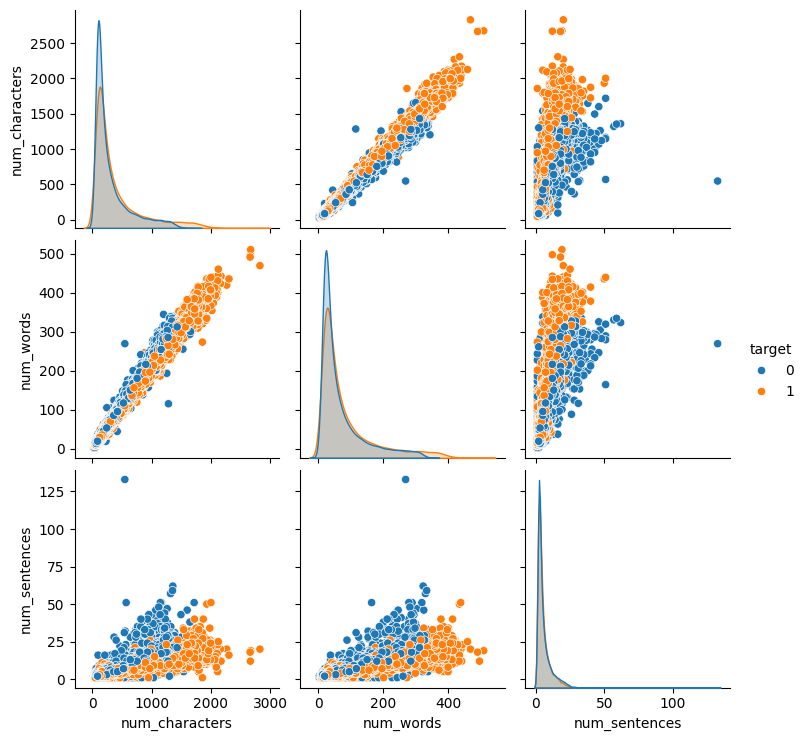

In [25]:
sns.pairplot(df,hue='target')
plt.show()

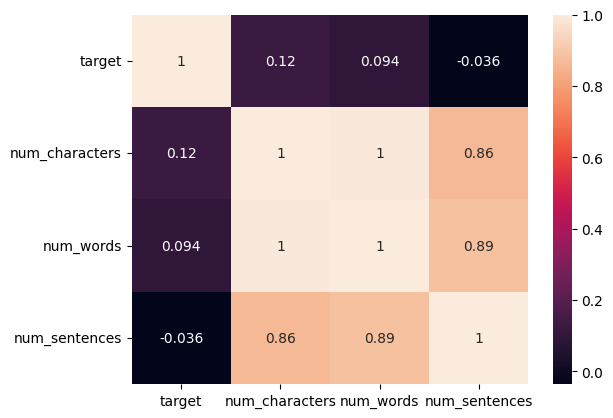

In [26]:
df_numeric = df.select_dtypes(include = 'number')
sns.heatmap(df_numeric.corr(),annot=True)

plt.show()

In [27]:
ps = PorterStemmer()

In [28]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
    
    return " ".join(y)

In [31]:
transform_text("I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.")

'gon na home soon want talk stuff anymor tonight k cri enough today'

In [32]:
df['transformed_text'] = df['text'].apply(transform_text)

In [33]:
df.head()

,text,target,num_characters,num_words,num_sentences,transformed_text
0,"I waited years for this book to be released, a...",0,614,152,14,wait year book releas wait releas date read co...
1,This was a DVD for my 2 year old grand daughte...,1,152,33,1,dvd 2 year old grand daughter seller great job...
2,"Finally found a new MC, an old friend, and a n...",0,886,187,13,final found new mc old friend new love interes...
3,I returned because this shoe fit like a mans. ...,1,79,20,2,return shoe fit like man way big women
4,"It is ok, just not what I expected. Very good ...",0,77,20,4,ok expect good qualiti nice bag pretti


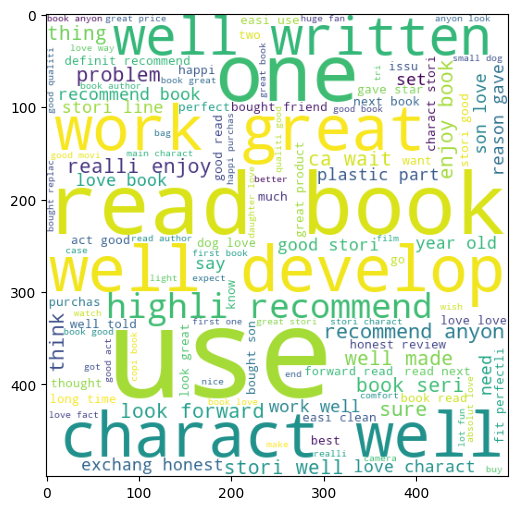

In [34]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
fake_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))

plt.figure(figsize=(15,6))
plt.imshow(fake_wc)

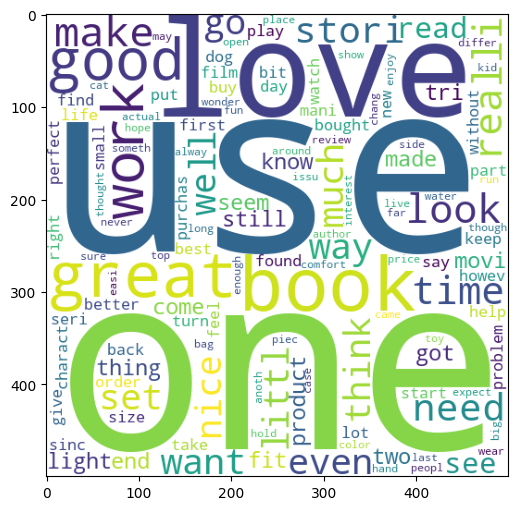

In [35]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
original_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))

plt.figure(figsize=(15,6))
plt.imshow(original_wc)

In [36]:
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

In [37]:
print(X.shape)
print(y.shape)

(40412, 3000)
(40412,)


In [38]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=32)

## Model training

In [39]:
# mnb = MultinomialNB()
# xgb = XGBClassifier(n_estimators=50,random_state=2)

knc = KNeighborsClassifier()
dtc = DecisionTreeClassifier(max_depth=5)
svc = SVC(probability=True, kernel='linear')
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)

In [ ]:
clfs = {
    'KN' : knc, 
    'SVC' : svc,
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc,
}

In [41]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    
    return accuracy,precision

## Model evaluation

In [ ]:
accuracy_scores = []
precision_scores = []

for name, clf in clfs.items():
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

In [ ]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)

In [ ]:
performance_df.reset_index(drop = True)

In [ ]:
# mnb = MultinomialNB()
svc = SVC(probability=True, kernel='linear')
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)

In [ ]:
voting = VotingClassifier(estimators=[('LR', lrc), ('svc', svc), ('RF', rfc)],voting='soft')

In [ ]:
voting.fit(X_train,y_train)

In [ ]:
y_pred = voting.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

In [ ]:
estimators = [('LR', lrc), ('svc', svc), ('RF', rfc)]
final_estimator = RandomForestClassifier(n_estimators=50, random_state=2)

In [ ]:
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

In [ ]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("Accuracy : ",accuracy_score(y_test,y_pred))
print("Precision : ",precision_score(y_test,y_pred))

## Pickling

In [ ]:
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(svc,open('model.pkl','wb'))